In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from torchvision import datasets, transforms
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from preprocessing import ImageDataset


In [2]:
dataset_path = '~/datasets'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 2, 'pin_memory': True} 

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-4

epochs = 50

# Model parameters
input_channels = 3
latent_dim = 20
num_components = 3

In [26]:
# Devine the Encoder
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim, num_components):
        super(Encoder, self).__init__()
        self.num_components = num_components  # Number of Gaussians (K)
        self.latent_dim = latent_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1)  

        self.flatten = nn.Flatten()

        # Fully connected layers for MoG parameters
        self.fc_mu = nn.Linear(32 ** 3, latent_dim * num_components)  # K means
        self.fc_logvar = nn.Linear(32 ** 3, latent_dim * num_components)  # K log variances
        self.fc_pi = nn.Linear(32 ** 3, num_components)  # Mixture weights

        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)

        # Compute mixture parameters
        mu = self.fc_mu(x).view(-1, self.num_components, self.latent_dim)  # (batch, K, d)
        logvar = self.fc_logvar(x).view(-1, self.num_components, self.latent_dim)
        logvar = F.softplus(logvar)  # Ensure positive variance
        pi = torch.softmax(self.fc_pi(x), dim=-1)  # Ensure valid probabilities

        return mu, logvar, pi


# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 32 ** 3)
        self.deconv1 = nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1)  
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 32, 32, 32)  
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  
        x = torch.sigmoid(self.deconv3(x))
        return x


# Define the Mixture of Gaussians VAE
class MoGVAE(nn.Module):
    def __init__(self, input_channels, latent_dim, num_components):
        super(MoGVAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim, num_components)
        self.decoder = Decoder(latent_dim, input_channels)
        self.num_components = num_components

    def reparameterize(self, mu, logvar, pi):
        batch_size, num_components, latent_dim = mu.shape

        # Sample a component index from the categorical distribution
        component_idx = torch.multinomial(pi, 1).squeeze(1)  # (batch,)

        # Gather selected Gaussian parameters
        mu_selected = mu[torch.arange(batch_size), component_idx]  # (batch, d)
        logvar_selected = logvar[torch.arange(batch_size), component_idx]

        # Standard reparameterization trick
        std = torch.exp(0.5 * logvar_selected)
        eps = torch.randn_like(std).to(DEVICE)
        z = mu_selected + eps * std
        return z, component_idx

    def forward(self, x):
        mu, logvar, pi = self.encoder(x)
        z, component_idx = self.reparameterize(mu, logvar, pi)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar, pi, component_idx
        
    


# KL Divergence for MoG
def mog_kl_divergence(mu, logvar, pi, num_components, latent_dim):
    prior_mu = torch.zeros(num_components, latent_dim).to(DEVICE)
    prior_logvar = torch.zeros(num_components, latent_dim).to(DEVICE)
    prior_pi = torch.ones(num_components).to(DEVICE) / num_components  # Uniform prior

    # Compute KL divergence per component
    kl = (logvar.exp() + (mu - prior_mu) ** 2) / prior_logvar.exp()
    kl = 0.5 * torch.sum(kl + prior_logvar - logvar - 1, dim=-1)

    # Weight KL by the mixture probabilities
    weighted_kl = torch.sum(pi * kl, dim=-1)  # Sum over K
    return weighted_kl.mean()  # Average over batch


# Loss Function
def loss_function(reconstructed, original, mu, logvar, pi, num_components, latent_dim):
    reconstruction_loss = F.mse_loss(reconstructed, original, reduction='sum')
    kl_div = mog_kl_divergence(mu, logvar, pi, num_components, latent_dim)
    return reconstruction_loss + kl_div


In [12]:
# Train on our dataset
image_dataset = ImageDataset("map_images_original/labels.csv", "map_images_original/")

#Split into train and test sets
indices = list(range(len(image_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)  # 80% train, 20% test
train_dataset = Subset(image_dataset, train_indices)
test_dataset = Subset(image_dataset, test_indices)


In [7]:

# Create a new DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

vae = MoGVAE(input_channels, latent_dim, num_components).to(DEVICE)
optimizer = Adam(vae.parameters(), lr=lr)

vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)

        optimizer.zero_grad()
        reconstructed, mu, logvar, pi, component_idx = vae(images)

        loss = loss_function(reconstructed, images, mu, logvar, pi, num_components, latent_dim)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    

# Saving the model and optimizer
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "MOG_VAE_checkpoint.pth")

C:\Users\Aes\anaconda3\envs\SeniorDesignProject\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch 1, Loss: 1227776.2776
Epoch 2, Loss: 325485.6207
Epoch 3, Loss: 218300.8540
Epoch 4, Loss: 188271.9957
Epoch 5, Loss: 167901.5430
Epoch 6, Loss: 155549.4549
Epoch 7, Loss: 148130.3514
Epoch 8, Loss: 142605.3056
Epoch 9, Loss: 138568.3438
Epoch 10, Loss: 135017.5319
Epoch 11, Loss: 128628.1386
Epoch 12, Loss: 123525.2723
Epoch 13, Loss: 119160.8085
Epoch 14, Loss: 115931.8679
Epoch 15, Loss: 113159.8335
Epoch 16, Loss: 111004.4189
Epoch 17, Loss: 108642.5285
Epoch 18, Loss: 106715.9850
Epoch 19, Loss: 104855.3599
Epoch 20, Loss: 102670.6848
Epoch 21, Loss: 100571.9003
Epoch 22, Loss: 99477.5867
Epoch 23, Loss: 98322.4545
Epoch 24, Loss: 97069.6685
Epoch 25, Loss: 95905.4485
Epoch 26, Loss: 94839.4069
Epoch 27, Loss: 93602.3554
Epoch 28, Loss: 92559.5518
Epoch 29, Loss: 91444.0879
Epoch 30, Loss: 90545.1568
Epoch 31, Loss: 89766.2223
Epoch 32, Loss: 88920.2935
Epoch 33, Loss: 88059.2697
Epoch 34, Loss: 87403.7999
Epoch 35, Loss: 86799.8513
Epoch 36, Loss: 86129.8582
Epoch 37, Loss:

In [28]:
test_loader = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

# Reloading the model and optimizer
checkpoint = torch.load("MOG_VAE_checkpoint.pth")
vae = MoGVAE(input_channels=input_channels, latent_dim=latent_dim, num_components=num_components)  # Reinitialize model
vae.load_state_dict(checkpoint['model_state_dict'])
vae.to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)  # Reinitialize optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

vae.eval()
for batch_idx, (test_images, _) in enumerate(test_loader):
    test_images = test_images.to(DEVICE)
    reconstructed, mu, logvar, pi, component_idx = vae(test_images)
    loss = loss_function(reconstructed, test_images, mu, logvar, pi, num_components, latent_dim)
print(loss.item() / batch_size)

C:\Users\Aes\AppData\Local\Temp\ipykernel_21144\164943851.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("MOG_VAE_checkpoint.pth")


307.38486328125
tensor([[[0.7716, 0.9029, 0.8791,  ..., 0.9019, 0.8963, 0.7996],
         [0.8741, 0.9370, 0.9090,  ..., 0.9241, 0.9131, 0.8920],
         [0.8728, 0.9246, 0.9103,  ..., 0.9186, 0.8971, 0.8855],
         ...,
         [0.8928, 0.9109, 0.9126,  ..., 0.9268, 0.9205, 0.8847],
         [0.8810, 0.9138, 0.9242,  ..., 0.9307, 0.9189, 0.8950],
         [0.7963, 0.8627, 0.8594,  ..., 0.8925, 0.8732, 0.7745]],

        [[0.7975, 0.9060, 0.9111,  ..., 0.9357, 0.9071, 0.8139],
         [0.8766, 0.9514, 0.9324,  ..., 0.9386, 0.9464, 0.9112],
         [0.9027, 0.9503, 0.9374,  ..., 0.9631, 0.9368, 0.9154],
         ...,
         [0.8962, 0.9528, 0.9446,  ..., 0.9472, 0.9273, 0.9026],
         [0.9279, 0.9532, 0.9566,  ..., 0.9519, 0.9552, 0.8950],
         [0.8141, 0.8935, 0.9028,  ..., 0.8951, 0.8953, 0.8037]],

        [[0.7988, 0.8933, 0.8963,  ..., 0.9105, 0.9032, 0.7794],
         [0.9085, 0.9369, 0.9487,  ..., 0.9563, 0.9593, 0.9272],
         [0.8838, 0.9220, 0.9163,  ..., 0.

In [9]:
def show_image(original_batch, reconstructed_batch, index):
    # Extract the specific image and move to CPU
    original = original_batch[index].detach().cpu()
    reconstructed = reconstructed_batch[index].detach().cpu()

    transform = T.Compose([
    T.ToPILImage()
    ])
    
    
    original = transform(original)
    reconstructed = transform(reconstructed)
    
        
    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Original image
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Reconstructed image
    axes[1].imshow(reconstructed)
    axes[1].set_title("Generated")
    axes[1].axis('off')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

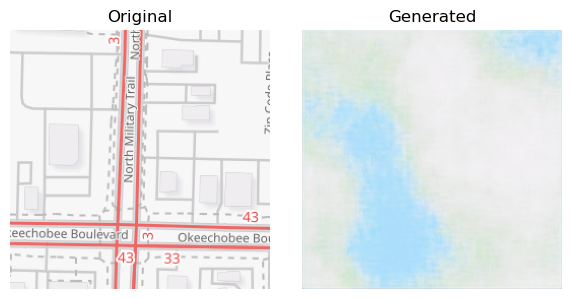

In [37]:
show_image(test_images, reconstructed, index=8)